# Identification of risk markers by interpretability approach

In [1]:
import os
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier 
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, \
                            confusion_matrix, accuracy_score, f1_score,recall_score
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold, cross_val_score, RepeatedKFold
import warnings
import pickle
import shap
shap.initjs()

warnings.filterwarnings('ignore')

In [2]:
"""Functions def"""
def read_data(raw_clinical_note):
    data = pd.read_csv(raw_clinical_note, header=0,na_filter=True)
    return data

def load_scaler(data,path):
    """Function for loading inverse_transform scaler"""
    scaler = pickle.load(open(path+'scaler','rb')) #load scaler
    np_array_rescale = scaler.inverse_transform(data)
    np_array_rescale = np.around(np_array_rescale,2)
    return np_array_rescale

def training(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,random_state=242)
  
    model = xgb.XGBClassifier(n_estimators=200,max_depth=5,gamma=2,subsample=0.3,
                              learning_rate = 0.03, objective = 'binary:logistic', 
                              seed = 422, eval_metric = "aucpr", reg_alpha= 0.03,
                              rate_drop = 0.3, scale_pos_weight = 6.127118644067797)
    model = model.fit(X_train,y_train) 
    return model

def plot_shap_values(model,patients,feature_list):
    """ Function for plotting global & local importances """
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patients)
    plt.title("Global feature importance")
    shap.summary_plot(shap_values,  patients, feature_names=feature_list, plot_type='bar',max_display=10)
    plt.title("Local explanation summary")
    shap.summary_plot(shap_values, patients,feature_names=feature_list,show = 'False',max_display=10)

def plot_waterfall(model,X,id):   #,name,logs_file
    explainerModel_prob = shap.TreeExplainer(model,
                                   data = shap.sample(X, 50),
                                   model_output='probability')
    

    shap_values_model_prob  = explainerModel_prob.shap_values(X)
    
    shap.plots._waterfall.waterfall_legacy(explainerModel_prob.expected_value,
                                           shap_values_model_prob[id,:],
                                           X.iloc[id,:],show=False,max_display=12)

In [3]:
"""Loading sets"""
path = "C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/BCM/"
x_train = pd.read_csv(path+"X_train.csv")
y_train = pd.read_csv(path+"y_train.csv")
x_test = pd.read_csv(path+"X_test.csv")
y_test = pd.read_csv(path+"y_test.csv")

In [4]:
y_train.columns

Index(['Unnamed: 0', 'lethality'], dtype='object')

In [5]:
"""Dropping column"""
x_train = x_train.drop(['Unnamed: 0'],axis=1)
x_test = x_test.drop(['Unnamed: 0'],axis=1)
y_train = y_train['lethality']
y_test = y_test['lethality']
feature_list = x_train.columns

In [6]:
"""Loading scaler"""
x_train_normal = load_scaler(x_train,path)
x_test_normal = load_scaler(x_test,path)

x_train_normal = pd.DataFrame(x_train_normal,columns = feature_list)
x_test_normal = pd.DataFrame(x_test_normal,columns = feature_list)

y_train = pd.DataFrame(y_train, columns = ['lethality'])
y_test = pd.DataFrame(y_test, columns = ['lethality'])

In [7]:
x_test_normal

,Sex,Age,Fever,Cough,Odynophagia,Dyspnea,Irritability,Diarrhea,Chest pain,Chills,...,COPD,Asthma,Immunosuppression,Hypertension,Cardiovascular disease,Obesity,CKD,Smoking,Use of antipyretics,Days elapsed
0,1.0,62.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,1.0,0.0,2.0
1,0.0,51.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,2.0
2,1.0,38.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,5.0
3,0.0,70.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
4,0.0,33.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,0.0,32.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,4.0
2309,1.0,56.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,3.0
2310,0.0,52.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,1.0,3.0
2311,1.0,27.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [8]:
"""Concatenate (x_train , x_test)"""
X = pd.concat([x_train_normal,x_test_normal]).astype(int)
Y = pd.concat([y_train, y_test]).astype(int)
feature_list = X.columns

In [9]:
X

,Sex,Age,Fever,Cough,Odynophagia,Dyspnea,Irritability,Diarrhea,Chest pain,Chills,...,COPD,Asthma,Immunosuppression,Hypertension,Cardiovascular disease,Obesity,CKD,Smoking,Use of antipyretics,Days elapsed
0,1,28,1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
1,0,55,1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,50,0,1,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,3
3,1,26,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8
4,0,46,0,1,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2308,0,32,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,4
2309,1,56,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,3
2310,0,52,1,1,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,1,3
2311,1,27,1,1,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,1,1


In [10]:
Y

,lethality
0,0
1,0
2,0
3,0
4,0
...,...
2308,0
2309,0
2310,0
2311,0


In [11]:
"""Concatenate  both  sets"""
data_set = pd.concat([X,Y], axis=1)

data_set

In [12]:
data_set.shape[0]

11564

# Identification of risk markers for Morelos population

In [13]:
data_set.columns

Index(['Sex', 'Age', 'Fever', 'Cough', 'Odynophagia', 'Dyspnea',
       'Irritability', 'Diarrhea', 'Chest pain', 'Chills', 'Headache',
       'Myalgia', 'Arthralgia', 'General discomfort', 'Rhinorrhea', 'Polypnea',
       'Vomiting', 'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed',
       'lethality'],
      dtype='object')

In [14]:
data_set['lethality'].value_counts()
print
Letality = np.where(data_set.lethality==1)
print("All (death):",Letality)

All (death): (array([    6,    33,    36, ..., 11543, 11548, 11563], dtype=int64),)


In [15]:
X = data_set.drop(['lethality'],axis=1)
y = data_set['lethality'].astype(int)
y = y.values.reshape(y.shape[0],1) 
feature_list = X.columns
print("X::", X.shape)
print("Y::", y.shape)

X:: (11564, 34)
Y:: (11564, 1)


In [16]:
model = training(X,y)

[02:29:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Population: (11564, 35)


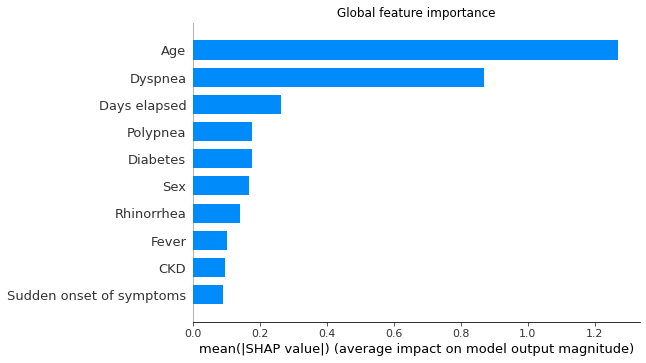

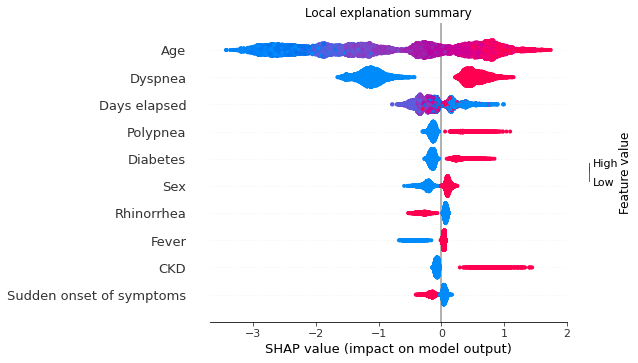

In [17]:
"""Risk markers for general population)"""
print("Population:",data_set.shape)
plot_shap_values(model,X,X.columns)

100%|===================| 11557/11564 [00:58<00:00]        

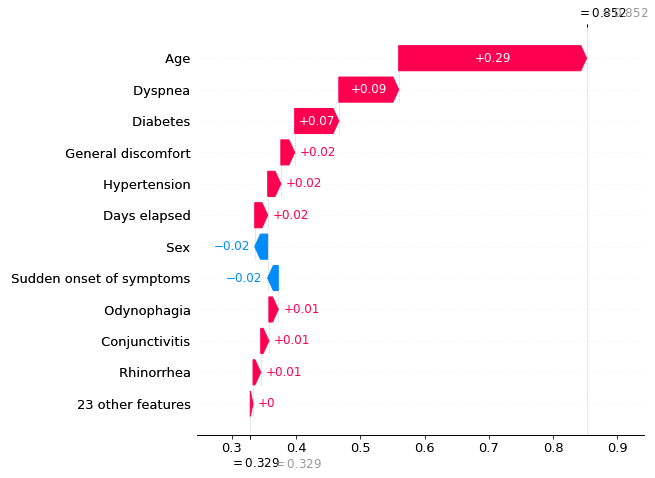

In [18]:
"""Individual explanation"""
id = 6
plot_waterfall(model,X,id) 
plt.savefig(path+'All patients id 6.pdf',bbox_inches='tight',)

In [19]:
"All patients",'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall'

('All patients',
 'C:/Users/Salvador/Modelo_COVID19/Libretas manuscrito/BCM Infectius diseases/waterfall')

# Identification of risk markers for men 

In [20]:
men = data_set[(data_set["Sex"]==1)]
X_men = men.drop(['Sex','Age','lethality'],axis=1)
feature_list_men = X_men.columns
y_men = men['lethality'].astype(int)
y_men = y_men.values.reshape(y_men.shape[0],1) 
print("Population:",X_men.shape)
print("Y::", y_men.shape)
print(feature_list_men)

Population: (6245, 32)
Y:: (6245, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [21]:
Letality_men = np.where(men.lethality==1)
print("All (death):",Letality_men)
men['lethality'].value_counts()

All (death): (array([  12,   14,   15, ..., 6230, 6231, 6244], dtype=int64),)


0    5161
1    1084
Name: lethality, dtype: int64

[02:30:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




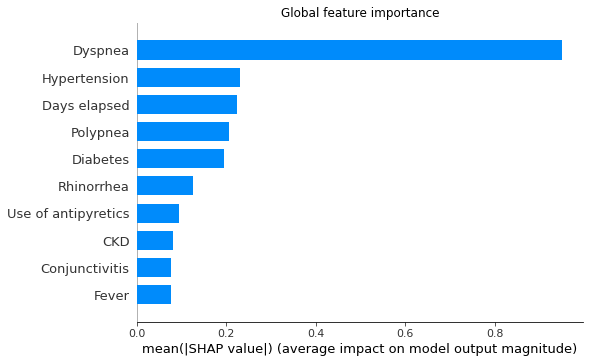

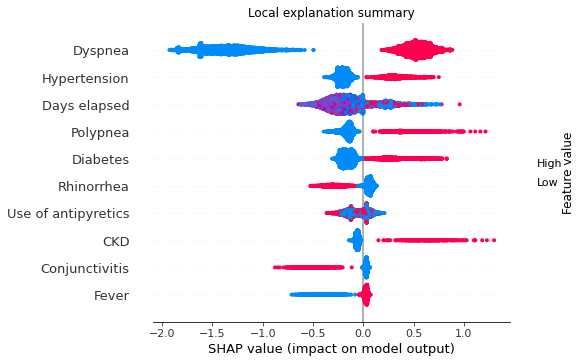

In [22]:
"""Risk markers for men"""
model_men = training(X_men,y_men)
plot_shap_values(model_men,X_men,X_men.columns)

100%|===================| 6224/6245 [00:27<00:00]        

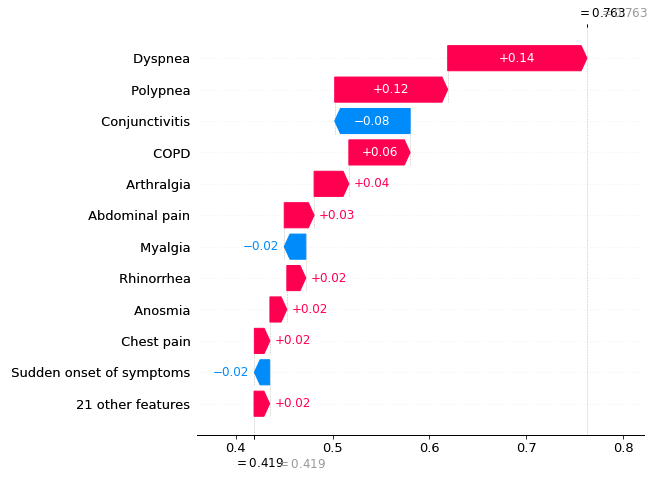

In [23]:
"""Individual explanation"""
id = 6230
plot_waterfall(model_men,X_men,id) 
plt.savefig(path+'All patients men id 6239.pdf',bbox_inches='tight',)

## Identification of risk markers for men aged 20 to 29

In [24]:
men_20_29 = men[(men["Age"]>=20) & ((men["Age"]<=29))]
X_men_20_29 = men_20_29.drop(['Sex','Age','lethality'],axis=1)
y_men_20_29 = men_20_29['lethality'].astype(int)
y_men_20_29 = y_men_20_29.values.reshape(y_men_20_29.shape[0],1)
feature_list_men_20_29 = X_men_20_29.columns
print("X::", X_men_20_29.shape)
print("Y::", y_men_20_29.shape)
print(feature_list_men_20_29)

X:: (657, 32)
Y:: (657, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [25]:
Letality_men_20_29 = np.where(men_20_29.lethality==1)
print("men 20-29 (death):",Letality_men_20_29)
men_20_29['lethality'].value_counts()

men 20-29 (death): (array([ 85, 107, 124, 128, 142, 172, 216, 251, 270, 293, 364, 438, 447,
       626], dtype=int64),)


0    643
1     14
Name: lethality, dtype: int64

[02:31:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




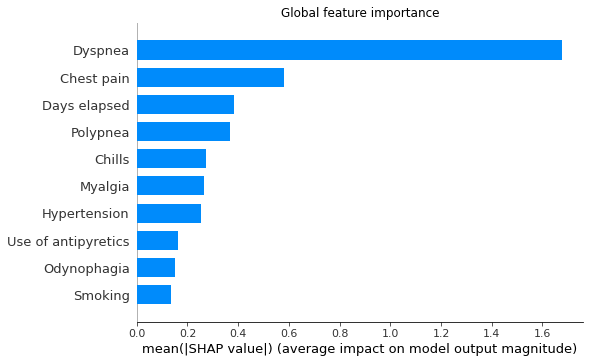

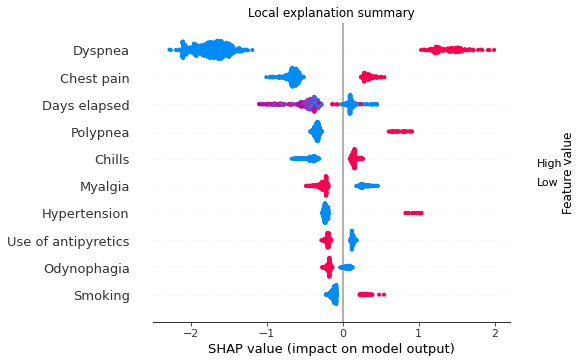

In [26]:
"""Risk markers for men (age from 20 to 29)"""
model_men_20_29 = training(X_men_20_29,y_men_20_29)
plot_shap_values(model_men_20_29,X_men_20_29,X_men_20_29.columns)

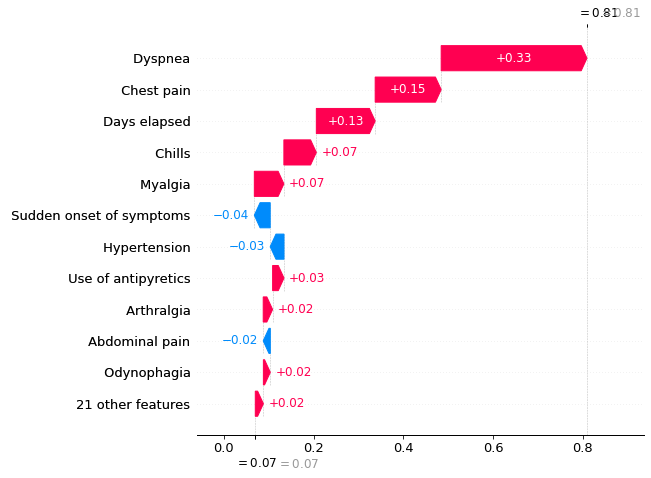

In [27]:
"""Individual explanation"""
id = 626
plot_waterfall(model_men_20_29,X_men_20_29,id) 
plt.savefig(path+'Patients men 20-29 id 626.pdf',bbox_inches='tight',)

## Identification of risk markers for men aged 30 to 39

In [28]:
men_30_39 = men[(men["Age"]>=30) & ((men["Age"]<=39))]
X_men_30_39 = men_30_39.drop(['Sex','Age','lethality'],axis=1)
y_men_30_39 = men_30_39['lethality'].astype(int)
y_men_30_39 = y_men_30_39.values.reshape(y_men_30_39.shape[0],1)
feature_list_men_30_39 = X_men_30_39.columns
print("X::", X_men_30_39.shape)
print("Y::", y_men_30_39.shape)
print(feature_list_men_30_39)

X:: (1091, 32)
Y:: (1091, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [29]:
Letality_men_30_39 = np.where(men_30_39.lethality==1)
print("men 30-39 (death):",Letality_men_30_39)
men_30_39['lethality'].value_counts()

men 30-39 (death): (array([   1,   17,   21,   58,   72,  107,  120,  131,  178,  196,  214,
        241,  271,  311,  334,  360,  376,  391,  411,  419,  468,  506,
        544,  579,  616,  627,  642,  645,  653,  733,  734,  830,  876,
        892,  952, 1024, 1053, 1081], dtype=int64),)


0    1053
1      38
Name: lethality, dtype: int64

[02:31:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




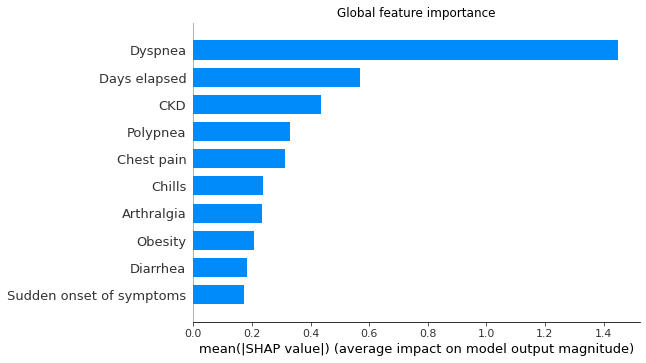

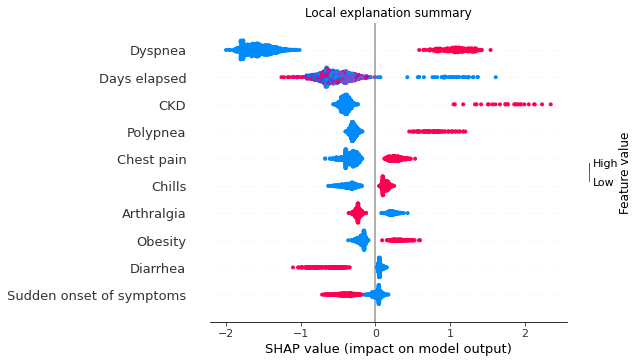

In [30]:
"""Risk markers for men (age from 30 to 39)"""
model_men_30_39 = training(X_men_30_39,y_men_30_39)
plot_shap_values(model_men_30_39,X_men_30_39,X_men_30_39.columns)

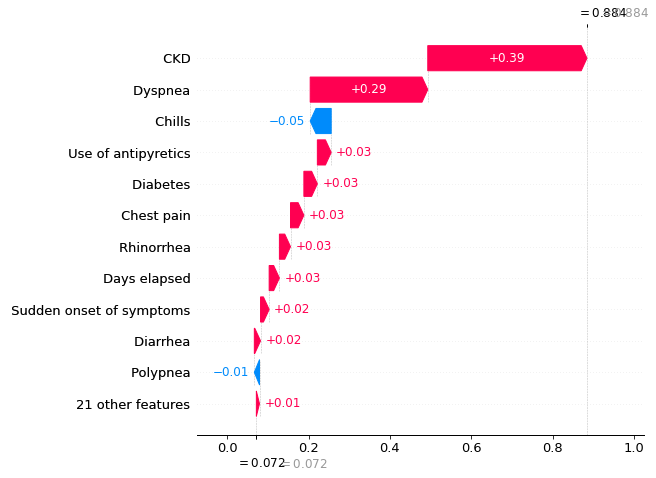

In [31]:
"""Individual explanation"""
id = 1
plot_waterfall(model_men_30_39,X_men_30_39,id) 
plt.savefig(path+'Patients men 30-39 id 1.pdf',bbox_inches='tight',)

## Identification of risk markers for men aged 40 to 49

In [32]:
men_40_49 = men[(men["Age"]>=40) & ((men["Age"]<=49))]
X_men_40_49 = men_40_49.drop(['Sex','Age','lethality'],axis=1)
y_men_40_49 = men_40_49['lethality'].astype(int)
y_men_40_49 = y_men_40_49.values.reshape(y_men_40_49.shape[0],1)
feature_list_men_40_49 = X_men_40_49.columns
print("X::", X_men_40_49.shape)
print("Y::", y_men_40_49.shape)
print(feature_list_men_40_49)

X:: (1149, 32)
Y:: (1149, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [33]:
Letality_men_40_49 = np.where(men_40_49.lethality==1)
print("men 30-39 (death):",Letality_men_40_49)
men_40_49['lethality'].value_counts()

men 30-39 (death): (array([  56,   65,   74,  104,  118,  127,  149,  153,  155,  159,  180,
        185,  186,  197,  201,  233,  264,  267,  269,  286,  288,  294,
        297,  302,  319,  326,  329,  347,  350,  355,  366,  376,  390,
        393,  397,  407,  430,  471,  472,  478,  484,  493,  502,  503,
        528,  537,  553,  567,  584,  585,  591,  599,  628,  642,  655,
        664,  692,  731,  733,  742,  744,  759,  765,  771,  772,  776,
        779,  781,  788,  792,  859,  864,  882,  884,  886,  916,  926,
        934,  957,  997, 1043, 1049, 1051, 1074, 1095, 1118, 1120, 1148],
      dtype=int64),)


0    1061
1      88
Name: lethality, dtype: int64

[02:31:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




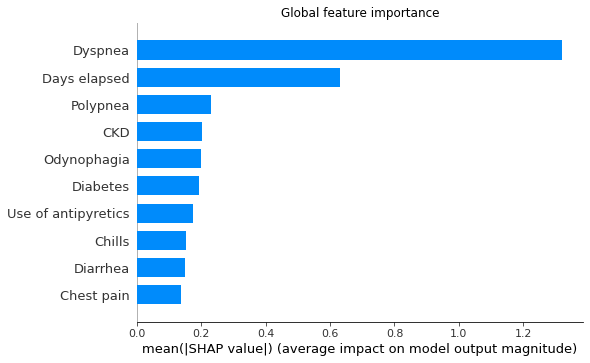

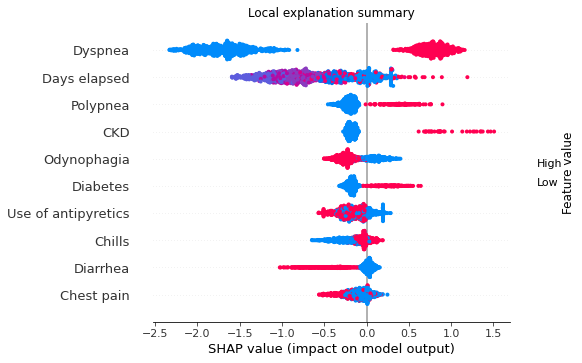

In [34]:
"""Risk markers for men (age from 40 to 49)"""
model_men_40_49 = training(X_men_40_49,y_men_40_49)
plot_shap_values(model_men_40_49,X_men_40_49,X_men_40_49.columns)

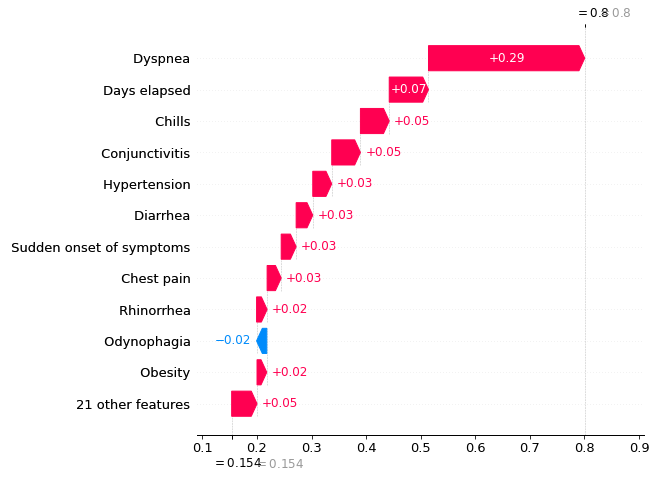

In [35]:
"""Individual explanation"""
id = 56
plot_waterfall(model_men_40_49,X_men_40_49,id) 
plt.savefig(path+'Patients men 40-49 id 56.pdf',bbox_inches='tight',)

## Identification of risk markers for men aged 50 to 59

In [36]:
men_50_59 = men[(men["Age"]>=50) & ((men["Age"]<=59))]
X_men_50_59 = men_50_59.drop(['Sex','Age','lethality'],axis=1)
y_men_50_59 = men_50_59['lethality'].astype(int)
y_men_50_59 = y_men_50_59.values.reshape(y_men_50_59.shape[0],1)
feature_list_men_50_59 = X_men_50_59.columns
print("X::", X_men_50_59.shape)
print("Y::", y_men_50_59.shape)
print(feature_list_men_50_59)

X:: (1150, 32)
Y:: (1150, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [37]:
Letality_men_50_59 = np.where(men_50_59.lethality==1)
print("men 50-59 (death):",Letality_men_50_59)
men_50_59['lethality'].value_counts()

men 50-59 (death): (array([  13,   14,   18,   21,   22,   24,   28,   38,   48,   54,   57,
         59,   83,   94,   96,   98,  100,  106,  121,  128,  130,  134,
        145,  152,  156,  159,  160,  162,  165,  169,  181,  194,  197,
        203,  205,  214,  217,  220,  222,  224,  227,  235,  239,  240,
        242,  250,  261,  267,  268,  281,  284,  285,  288,  289,  298,
        305,  308,  313,  322,  324,  333,  337,  339,  343,  348,  354,
        360,  384,  389,  398,  402,  410,  424,  429,  430,  432,  433,
        441,  442,  448,  451,  452,  456,  457,  461,  467,  471,  474,
        476,  480,  487,  494,  499,  503,  506,  520,  526,  557,  559,
        560,  561,  565,  572,  573,  584,  585,  586,  591,  613,  625,
        634,  640,  641,  643,  644,  646,  664,  678,  680,  689,  695,
        699,  700,  715,  721,  724,  730,  741,  743,  745,  748,  749,
        752,  754,  760,  762,  765,  771,  778,  784,  785,  786,  789,
        797,  799,  806,  807, 

0    947
1    203
Name: lethality, dtype: int64

[02:31:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




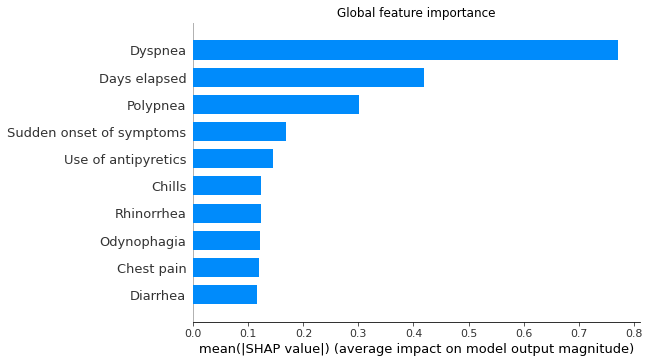

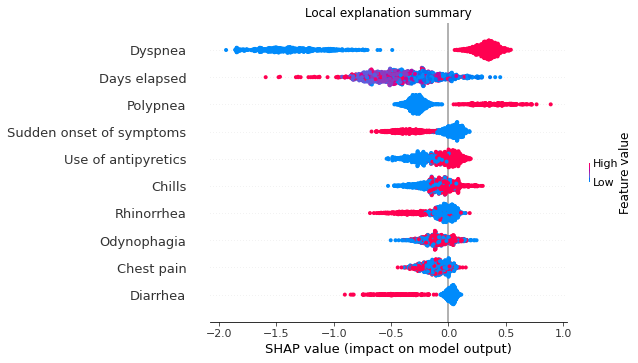

In [38]:
"""Risk markers for men (age from 50 to 59)"""
model_men_50_59 = training(X_men_50_59,y_men_50_59)
plot_shap_values(model_men_50_59,X_men_50_59,X_men_50_59.columns)

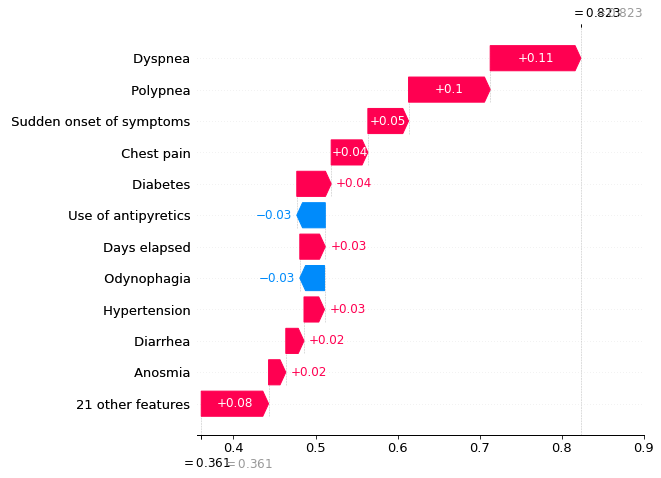

In [39]:
"""Individual explanation"""
id = 38
plot_waterfall(model_men_50_59,X_men_50_59,id) 
plt.savefig(path+'Patients men 50-59 id 38.pdf',bbox_inches='tight',)

## Identification of risk markers for men aged 60 to 69

In [40]:
men_60_69 = men[(men["Age"]>=60) & ((men["Age"]<=69))]
X_men_60_69 = men_60_69.drop(['Sex','Age','lethality'],axis=1)
y_men_60_69 = men_60_69['lethality'].astype(int)
y_men_60_69 = y_men_60_69.values.reshape(y_men_60_69.shape[0],1)
feature_list_men_60_69 = X_men_60_69.columns
print("X::", X_men_60_69.shape)
print("Y::", y_men_60_69.shape)
print(feature_list_men_60_69)

X:: (1034, 32)
Y:: (1034, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [41]:
Letality_men_60_69 = np.where(men_60_69.lethality==1)
print("men 60-69 (death):",Letality_men_60_69)
men_60_69['lethality'].value_counts()

men 60-69 (death): (array([   2,    4,    7,    9,   11,   13,   14,   15,   24,   25,   27,
         30,   32,   34,   36,   39,   41,   42,   43,   49,   51,   52,
         55,   67,   68,   70,   78,   80,   84,   87,   90,   93,   96,
        103,  107,  110,  113,  117,  119,  122,  123,  126,  127,  129,
        137,  140,  141,  146,  150,  151,  154,  155,  156,  167,  170,
        173,  178,  180,  182,  184,  185,  187,  189,  192,  193,  201,
        215,  220,  221,  223,  225,  226,  235,  237,  238,  240,  242,
        245,  250,  251,  255,  256,  281,  284,  286,  288,  292,  295,
        297,  298,  299,  302,  306,  309,  310,  311,  312,  314,  315,
        318,  322,  323,  324,  330,  331,  335,  341,  350,  353,  356,
        359,  361,  362,  364,  366,  368,  369,  374,  376,  377,  379,
        380,  394,  401,  403,  407,  408,  420,  423,  426,  427,  439,
        440,  442,  443,  444,  445,  447,  449,  457,  459,  460,  466,
        467,  469,  470,  474, 

0    724
1    310
Name: lethality, dtype: int64

[02:31:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




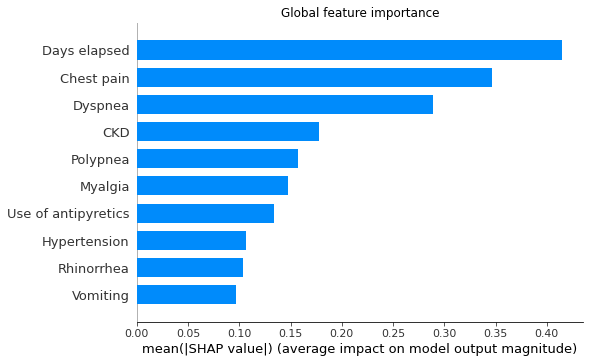

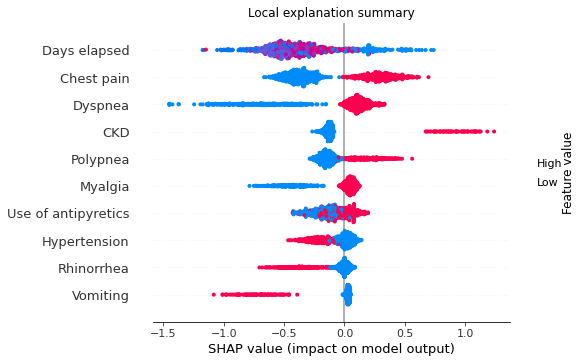

In [42]:
"""Risk markers for men (age from 60 to 69)"""
model_men_60_69 = training(X_men_60_69,y_men_60_69)
plot_shap_values(model_men_60_69,X_men_60_69,X_men_60_69.columns)

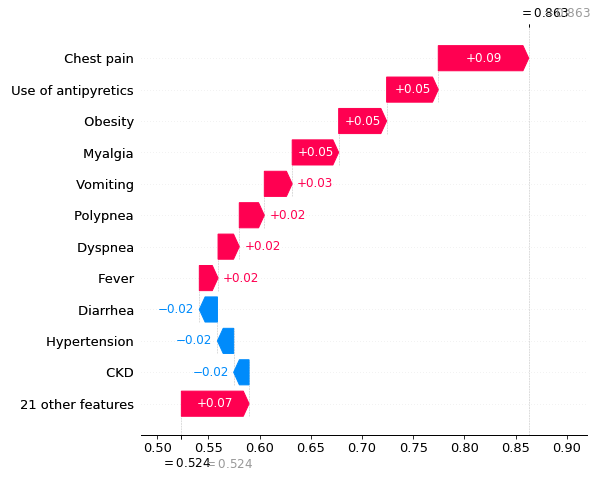

In [43]:
"""Individual explanation"""
id = 2
plot_waterfall(model_men_60_69,X_men_60_69,id) 
plt.savefig(path+'Patients men 60-69 id 2.pdf',bbox_inches='tight',)

## Identification of risk markers for men aged 70and over

In [44]:
men_70 = men[(men["Age"]>=70)]
X_men_70 = men_70.drop(['Sex','Age','lethality'],axis=1)
y_men_70 = men_70['lethality'].astype(int)
y_men_70 = y_men_70.values.reshape(y_men_70.shape[0],1)
feature_list_men_70 = X_men_70.columns
print("X::", X_men_70.shape)
print("Y::", y_men_70.shape)
print(feature_list_men_70)

X:: (1030, 32)
Y:: (1030, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [45]:
Letality_men_70 = np.where(men_70.lethality==1)
print("men 70 (death):",Letality_men_70)
men_70['lethality'].value_counts()

men 70 (death): (array([   0,    2,    4,    6,    8,   10,   11,   13,   16,   17,   22,
         27,   28,   30,   31,   33,   34,   37,   38,   40,   42,   44,
         47,   48,   54,   58,   59,   62,   63,   64,   65,   67,   68,
         70,   71,   75,   85,   88,   92,   97,  102,  103,  106,  108,
        111,  112,  114,  116,  118,  119,  122,  127,  128,  130,  132,
        133,  134,  136,  137,  141,  142,  143,  145,  152,  154,  158,
        163,  164,  166,  168,  169,  175,  176,  179,  180,  183,  184,
        185,  189,  190,  191,  197,  198,  199,  201,  203,  204,  206,
        208,  212,  213,  214,  215,  218,  220,  221,  222,  224,  227,
        231,  232,  233,  235,  236,  240,  248,  255,  256,  258,  263,
        265,  267,  268,  269,  271,  272,  276,  281,  282,  285,  286,
        288,  291,  297,  298,  300,  302,  303,  304,  306,  308,  310,
        312,  313,  316,  317,  318,  322,  323,  326,  327,  328,  329,
        334,  340,  342,  344,  34

0    601
1    429
Name: lethality, dtype: int64

[02:31:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




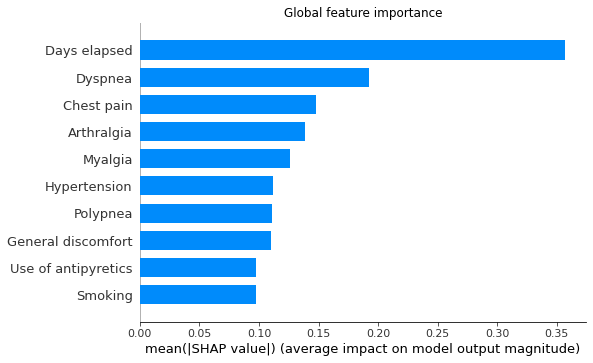

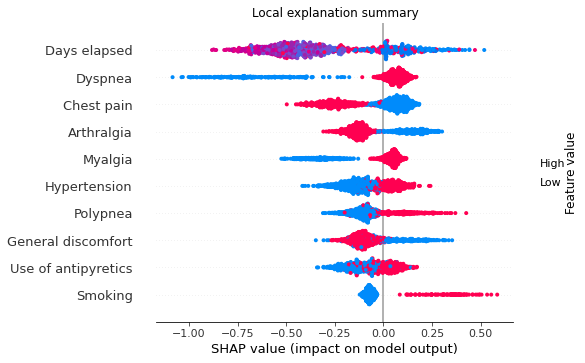

In [46]:
"""Risk markers for men (age from 70 and over)"""
model_men_70 = training(X_men_70,y_men_70)
plot_shap_values(model_men_70,X_men_70,X_men_70.columns)

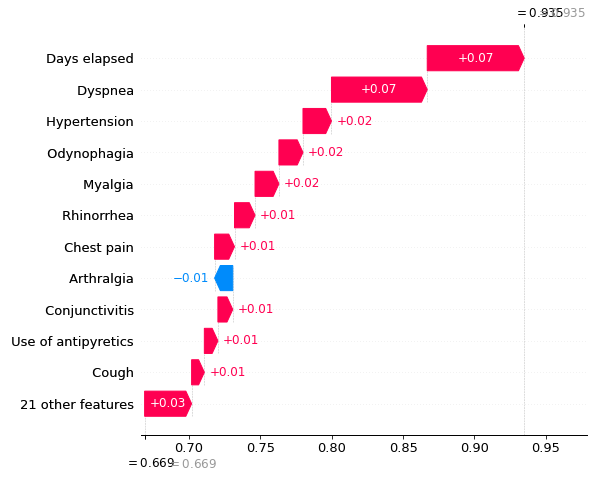

In [47]:
"""Individual explanation"""
id = 70
plot_waterfall(model_men_70,X_men_70,id) 
plt.savefig(path+'Patients men 70-79 id 70.pdf',bbox_inches='tight',)

# Identification of risk markers for women 

In [48]:
women = data_set[(data_set["Sex"]==0)]
X_women = women.drop(['Sex','Age','lethality'],axis=1)
feature_list_womwen = X_women.columns
y_women = women['lethality'].astype(int)
y_women = y_women.values.reshape(y_women.shape[0],1) 
print("Population:",X_women.shape)
print("Y::", y_women.shape)
print(feature_list_womwen)

Population: (5319, 32)
Y:: (5319, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [49]:
Letality_women = np.where(women.lethality==1)
print("women (death):",Letality_women)
women['lethality'].value_counts()

women (death): (array([   4,   22,   38,   67,   69,   70,   78,   83,   85,   86,   93,
         98,   99,  105,  137,  153,  157,  242,  249,  257,  269,  270,
        289,  294,  317,  345,  346,  350,  366,  375,  378,  380,  392,
        396,  397,  433,  451,  457,  486,  490,  520,  522,  523,  545,
        546,  558,  561,  573,  590,  594,  602,  604,  613,  614,  616,
        625,  636,  646,  647,  653,  658,  676,  717,  718,  720,  757,
        767,  768,  772,  777,  779,  782,  791,  793,  794,  806,  808,
        809,  811,  826,  836,  845,  850,  853,  863,  871,  896,  902,
        922,  932,  956,  963,  972,  980, 1001, 1007, 1008, 1009, 1023,
       1030, 1043, 1054, 1061, 1073, 1082, 1093, 1101, 1113, 1116, 1118,
       1126, 1136, 1137, 1144, 1159, 1166, 1191, 1204, 1207, 1214, 1215,
       1225, 1229, 1252, 1257, 1287, 1296, 1303, 1311, 1312, 1344, 1366,
       1367, 1379, 1386, 1396, 1401, 1453, 1456, 1462, 1471, 1482, 1531,
       1546, 1549, 1560, 1562, 1564

0    4781
1     538
Name: lethality, dtype: int64

[02:31:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




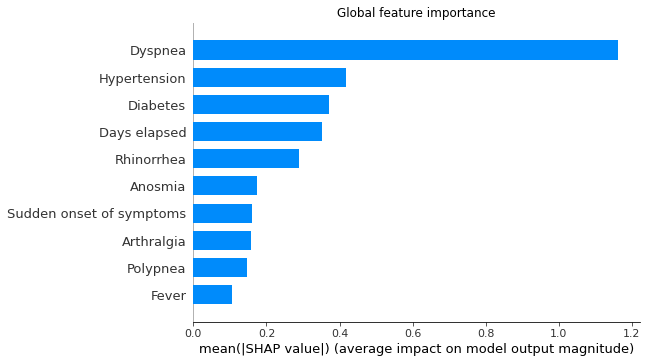

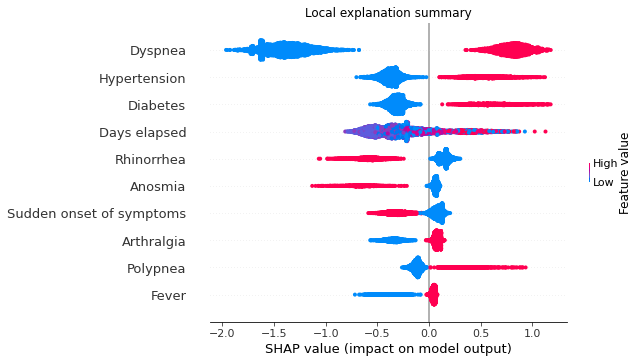

In [50]:
"""Risk markers for women"""
model_women = training(X_women,y_women)
plot_shap_values(model_women,X_women,X_women.columns)

 97%|=================== | 5138/5319 [00:20<00:00]       

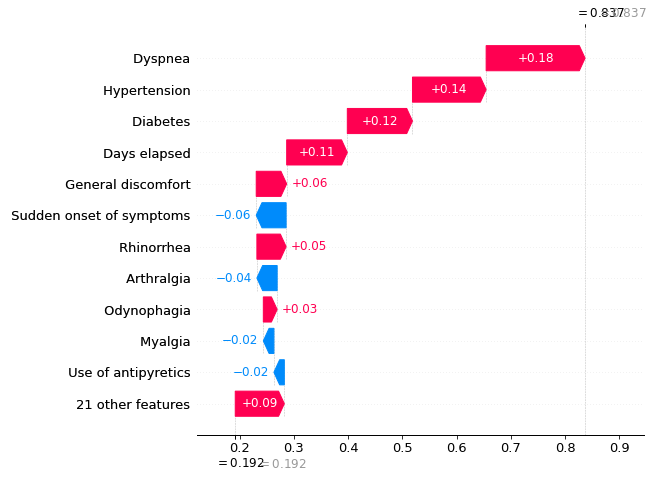

In [51]:
"""Individual explanation"""
id = 4
plot_waterfall(model_women,X_women,id) 
plt.savefig(path+'Patients women id 4.pdf',bbox_inches='tight',)

## Identification of risk markers for women aged 30 to 39

In [52]:
women_30_39 = women[(women["Age"]>=30) & ((women["Age"]<=39))]
X_women_30_39 = women_30_39.drop(['Sex','Age','lethality'],axis=1)
feature_list_women_30_39 = X_women_30_39.columns
y_women_30_39 = women_30_39['lethality'].astype(int)
y_women_30_39 = y_women_30_39.values.reshape(y_women_30_39.shape[0],1)
print("X::", X_women_30_39.shape)
print("Y::", y_women_30_39.shape)
print(feature_list_women_30_39)

X:: (1127, 32)
Y:: (1127, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [53]:
Letality_women_30_39 = np.where(women_30_39.lethality==1)
print("women 30-39 (death):",Letality_women_30_39)
women_30_39['lethality'].value_counts()

women 30-39 (death): (array([ 100,  118,  153,  192,  215,  224,  357,  506,  508,  518,  547,
        549,  625,  645,  652,  740,  818,  896, 1021, 1069], dtype=int64),)


0    1107
1      20
Name: lethality, dtype: int64

[02:32:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




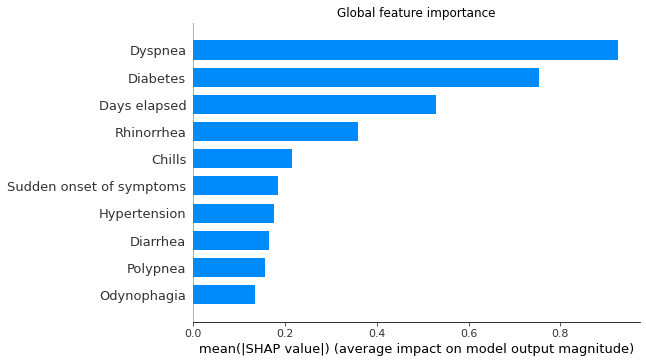

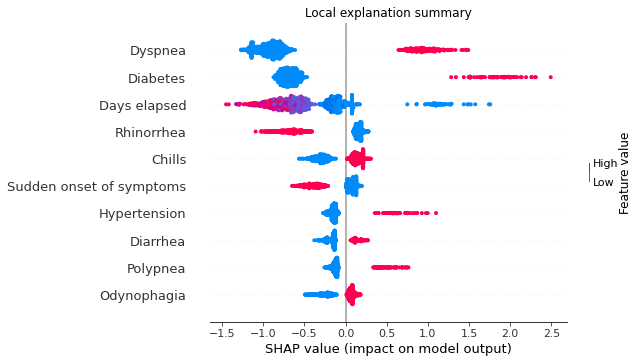

In [54]:
"""Risk markers for women (age from 30 to 39)"""
model_women_30_39 = training(X_women_30_39,y_women_30_39)
plot_shap_values(model_women_30_39,X_women_30_39,X_women_30_39.columns)

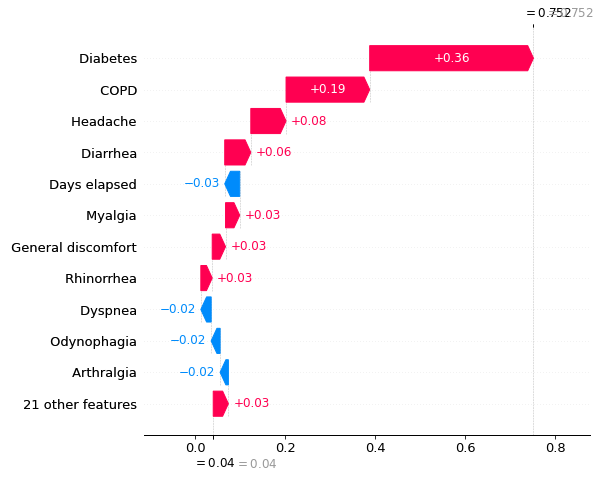

In [55]:
"""Individual explanation"""
id = 625
plot_waterfall(model_women_30_39,X_women_30_39,id) 
plt.savefig(path+'Patients women 30-39 id 625.pdf',bbox_inches='tight',)

## Identification of risk markers for women aged 40 to 49

In [56]:
women_40_49 = women[(women["Age"]>=40) & ((women["Age"]<=49))]
X_women_40_49 = women_40_49.drop(['Sex','Age','lethality'],axis=1)
y_women_40_49 = women_40_49['lethality'].astype(int)
y_women_40_49 = y_women_40_49.values.reshape(y_women_40_49.shape[0],1)
feature_list_women_40_49 = X_women_40_49.columns
print("X::", X_women_40_49.shape)
print("Y::", y_women_40_49.shape)
print(feature_list_women_40_49)

X:: (1072, 32)
Y:: (1072, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [57]:
Letality_women_40_49 = np.where(women_40_49.lethality==1)
print("women 40-49 (death):",Letality_women_40_49)
women_40_49['lethality'].value_counts()

women 40-49 (death): (array([   8,  130,  138,  155,  169,  214,  218,  241,  243,  301,  306,
        398,  428,  495,  530,  556,  572,  602,  612,  640,  656,  708,
        751,  812,  873,  879,  880,  898, 1012, 1054], dtype=int64),)


0    1042
1      30
Name: lethality, dtype: int64

[02:32:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




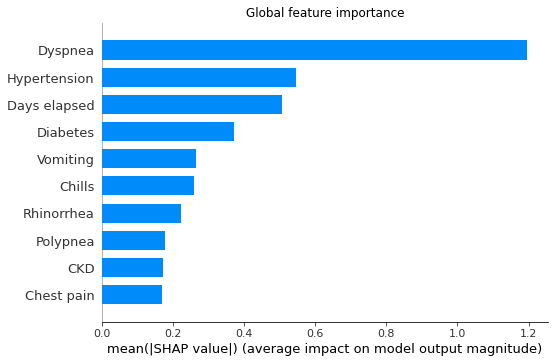

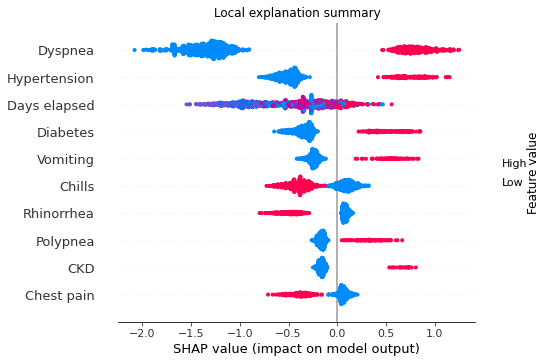

In [58]:
"""Risk markers for women (age from 40 to 49)"""
model_women_40_49 = training(X_women_40_49,y_women_40_49)
plot_shap_values(model_women_40_49,X_women_40_49,X_women_40_49.columns)

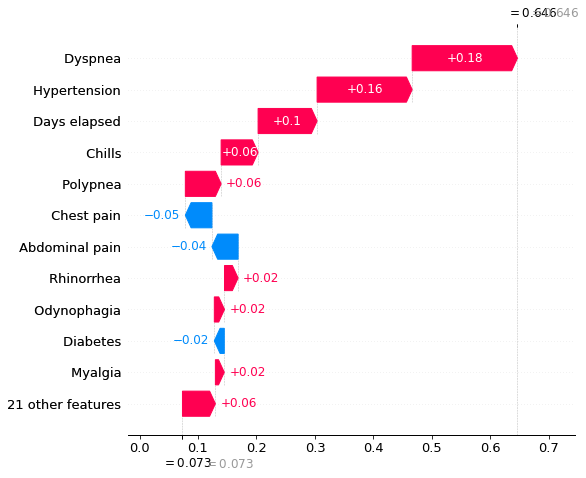

In [59]:
"""Individual explanation"""
id = 130
plot_waterfall(model_women_40_49,X_women_40_49,id) 
plt.savefig(path+'Patients women 40-49 id 130.pdf',bbox_inches='tight',)

## Identification of risk markers for women aged 50 to 59

In [60]:
women_50_59 = women[(women["Age"]>=50) & ((women["Age"]<=59))]
X_women_50_59 = women_50_59.drop(['Sex','Age','lethality'],axis=1)
y_women_50_59 = women_50_59['lethality'].astype(int)
y_women_50_59 = y_women_50_59.values.reshape(y_women_50_59.shape[0],1)
feature_list_women_50_59 = X_women_50_59.columns
print("X::", X_women_50_59.shape)
print("Y::", y_women_50_59.shape)
print(feature_list_women_50_59)

X:: (951, 32)
Y:: (951, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [61]:
Letality_women_50_59 = np.where(women_50_59.lethality==1)
print("women 50-59 (death):",Letality_women_50_59)
women_50_59['lethality'].value_counts()

women 50-59 (death): (array([ 17,  18,  21,  22,  25,  35,  58,  84,  90, 102, 106, 115, 120,
       144, 150, 152, 153, 158, 159, 172, 201, 206, 214, 215, 234, 235,
       271, 273, 314, 330, 331, 332, 337, 351, 367, 374, 389, 393, 394,
       404, 420, 427, 445, 446, 456, 462, 474, 479, 490, 517, 529, 549,
       554, 557, 558, 576, 581, 600, 609, 622, 628, 646, 647, 660, 661,
       674, 682, 690, 695, 708, 710, 719, 730, 740, 747, 767, 770, 777,
       783, 790, 796, 797, 807, 808, 824, 825, 827, 841, 849, 850, 853,
       866, 876, 880, 881, 882, 890, 895, 901, 906, 912, 914, 930, 939],
      dtype=int64),)


0    847
1    104
Name: lethality, dtype: int64

[02:32:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




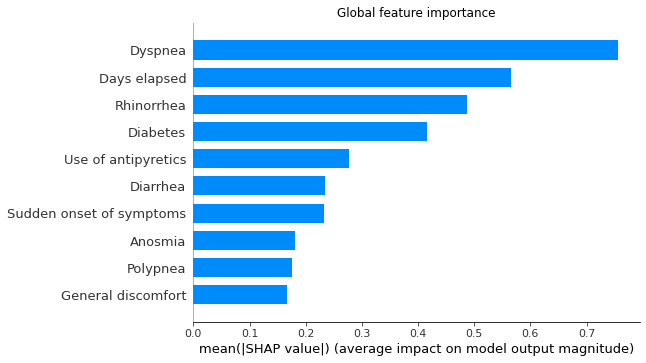

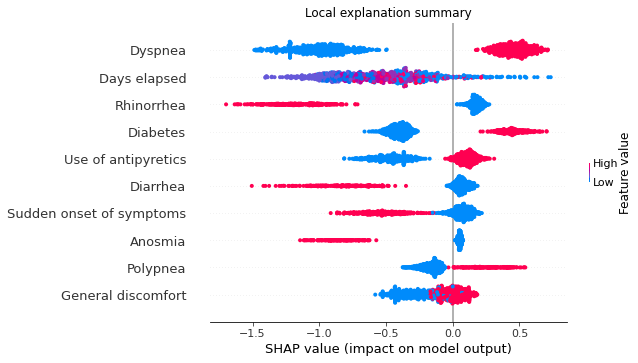

In [62]:
"""Risk markers for women (age from 50 to 59)"""
model_women_50_59 = training(X_women_50_59,y_women_50_59)
plot_shap_values(model_women_50_59,X_women_50_59,X_women_50_59.columns)

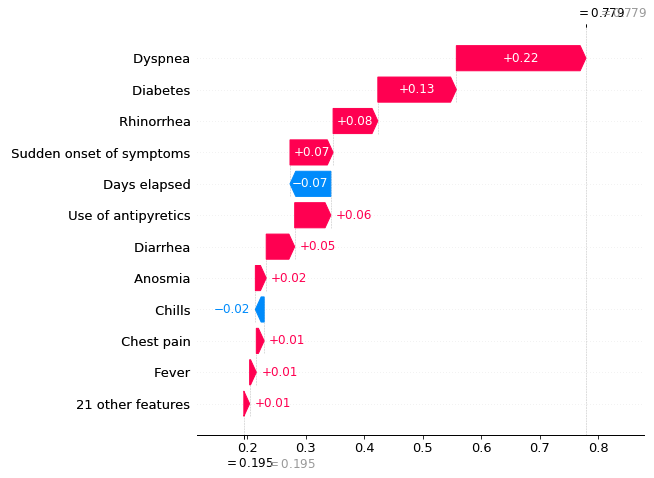

In [63]:
"""Individual explanation"""
id = 330
plot_waterfall(model_women_50_59,X_women_50_59,id) 
plt.savefig(path+'Patients women 50-59 id 330.pdf',bbox_inches='tight',)

## Identification of risk markers for women aged 60 to 69

In [64]:
women_60_69 = women[(women["Age"]>=60) & ((women["Age"]<=69))]
X_women_60_69 = women_60_69.drop(['Sex','Age','lethality'],axis=1)
y_women_60_69 = women_60_69['lethality'].astype(int)
y_women_60_69 = y_women_60_69.values.reshape(y_women_60_69.shape[0],1)
feature_list_women_60_69 = X_women_60_69.columns
print("X::", X_women_60_69.shape)
print("Y::", y_women_60_69.shape)
print(feature_list_women_60_69)

X:: (700, 32)
Y:: (700, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [65]:
Letality_women_60_69 = np.where(women_60_69.lethality==1)
print("women 60-69 (death):",Letality_women_60_69)
women_60_69['lethality'].value_counts()

women 60-69 (death): (array([  5,   6,  20,  30,  33,  37,  41,  48,  49,  54,  59,  60,  64,
        72,  73,  75,  86, 100, 101, 107, 108, 110, 111, 115, 138, 139,
       153, 156, 163, 167, 178, 184, 185, 198, 199, 200, 201, 206, 209,
       211, 216, 222, 225, 227, 231, 233, 237, 240, 243, 245, 249, 252,
       253, 257, 259, 261, 269, 276, 281, 282, 283, 287, 312, 314, 320,
       321, 326, 329, 333, 335, 336, 339, 345, 350, 351, 359, 360, 365,
       368, 369, 372, 373, 375, 382, 385, 392, 399, 400, 403, 408, 411,
       412, 415, 418, 420, 423, 427, 438, 443, 445, 447, 449, 451, 454,
       456, 457, 470, 476, 481, 487, 489, 493, 498, 502, 506, 512, 513,
       519, 522, 525, 530, 534, 535, 536, 540, 541, 542, 547, 549, 552,
       556, 558, 559, 561, 570, 573, 574, 575, 581, 583, 584, 588, 596,
       600, 606, 612, 620, 621, 623, 624, 628, 632, 635, 642, 647, 648,
       656, 670, 675, 682, 685, 692, 694, 699], dtype=int64),)


0    536
1    164
Name: lethality, dtype: int64

[02:32:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




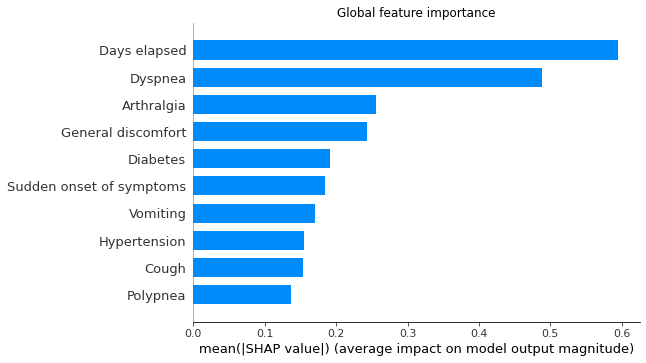

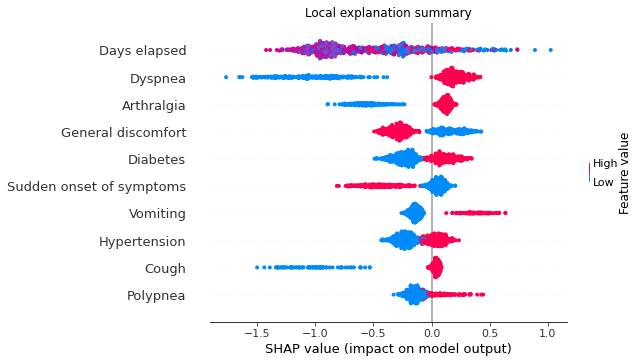

In [66]:
"""Risk markers for women (age from 60 to 69)"""
model_women_60_69 = training(X_women_60_69,y_women_60_69)
plot_shap_values(model_women_60_69,X_women_60_69,X_women_60_69.columns)

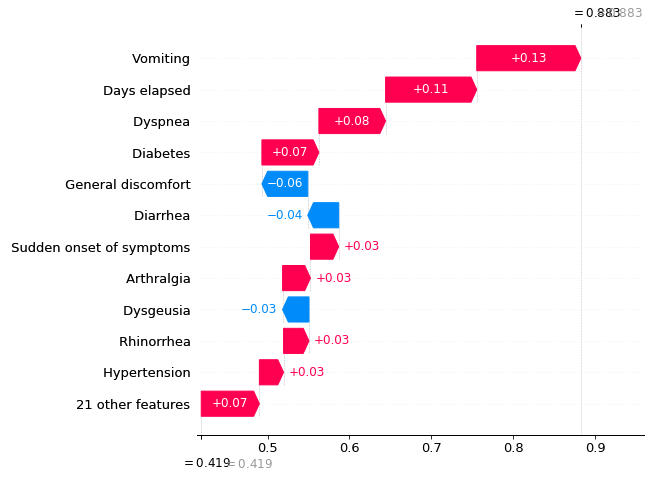

In [67]:
"""Individual explanation"""
id = 536
plot_waterfall(model_women_60_69,X_women_60_69,id) 
plt.savefig(path+'Patients women 60-69 id 536.pdf',bbox_inches='tight',)

## Identification of risk markers for women aged 70and over

In [68]:
women_70 = women[(women["Age"]>=70)]
X_women_70 = women_70.drop(['Sex','Age','lethality'],axis=1)
y_women_70 = women_70['lethality'].astype(int)
y_women_70 = y_women_70.values.reshape(y_women_70.shape[0],1)
feature_list_women_70 = X_women_70.columns
print("X::", X_women_70.shape)
print("Y::", y_women_70.shape)
print(feature_list_women_70)

X:: (633, 32)
Y:: (633, 1)
Index(['Fever', 'Cough', 'Odynophagia', 'Dyspnea', 'Irritability', 'Diarrhea',
       'Chest pain', 'Chills', 'Headache', 'Myalgia', 'Arthralgia',
       'General discomfort', 'Rhinorrhea', 'Polypnea', 'Vomiting',
       'Abdominal pain', 'Conjunctivitis', 'Cyanosis',
       'Sudden onset of symptoms', 'Anosmia', 'Dysgeusia', 'Diabetes', 'COPD',
       'Asthma', 'Immunosuppression', 'Hypertension', 'Cardiovascular disease',
       'Obesity', 'CKD', 'Smoking', 'Use of antipyretics', 'Days elapsed'],
      dtype='object')


In [69]:
Letality_women_70 = np.where(women_70.lethality==1)
print("women 70 (death):",Letality_women_70)
women_70['lethality'].value_counts()

women 70 (death): (array([  0,   3,   7,   9,  10,  11,  16,  23,  26,  30,  35,  36,  37,
        38,  40,  41,  48,  52,  56,  59,  61,  62,  63,  66,  68,  69,
        70,  74,  82,  85,  86,  90,  96,  98,  99, 102, 103, 106, 113,
       115, 116, 119, 120, 123, 124, 126, 130, 133, 135, 137, 145, 148,
       150, 157, 158, 159, 161, 164, 168, 171, 174, 177, 183, 184, 185,
       188, 192, 194, 195, 196, 197, 199, 202, 203, 207, 213, 216, 223,
       224, 225, 227, 228, 231, 232, 238, 240, 244, 248, 254, 255, 256,
       261, 264, 265, 271, 272, 273, 274, 275, 276, 282, 285, 286, 288,
       295, 296, 300, 304, 306, 324, 325, 327, 329, 331, 333, 336, 337,
       338, 339, 340, 343, 344, 349, 352, 353, 357, 359, 360, 363, 367,
       369, 380, 384, 386, 387, 388, 390, 394, 396, 401, 402, 408, 414,
       417, 423, 426, 427, 428, 429, 433, 438, 440, 442, 447, 449, 454,
       455, 457, 458, 460, 461, 470, 473, 478, 480, 484, 487, 493, 497,
       499, 500, 516, 517, 518, 519, 521, 525

0    416
1    217
Name: lethality, dtype: int64

[02:32:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { rate_drop } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




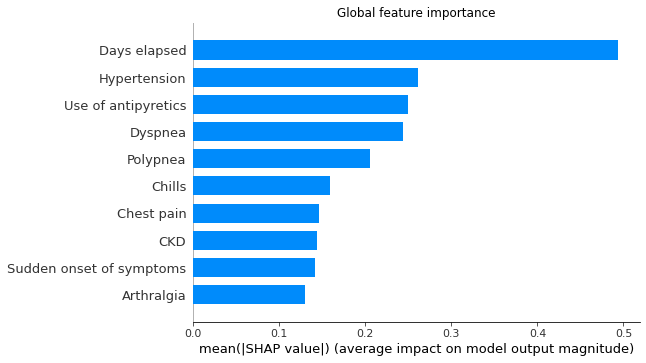

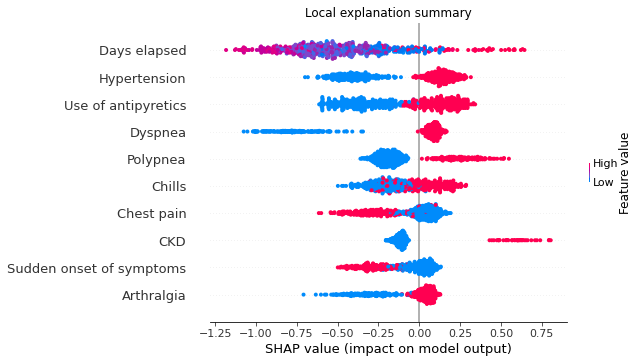

In [70]:
"""Risk markers for women (age from 70 to 79)"""
model_women_70 = training(X_women_70,y_women_70)
plot_shap_values(model_women_70,X_women_70,X_women_70.columns)

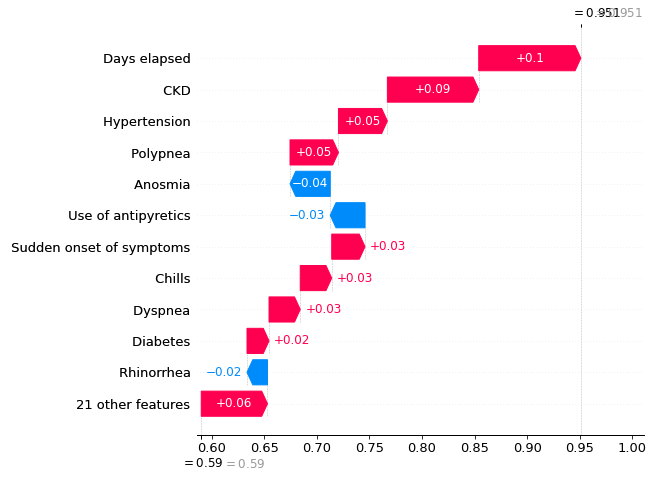

In [71]:
"""Individual explanation"""
id = 62
plot_waterfall(model_women_70,X_women_70,id) 
plt.savefig(path+'Patients women 70 id 62.pdf',bbox_inches='tight',)